In [41]:
#필요한 패키지 임포트

In [42]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [43]:
#Step 1. 실험환경 Set-up

In [79]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 10 # 배치 사이즈 설정
EPOCHS = 20 # 에폭 설정

In [45]:
#Step 2. 데이터 준비하기

In [46]:
#데이터 가져오기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [47]:
#데이터 갯수 확인

print(len(train_filenames)) #train 5216
print(len(val_filenames)) #val 16
print(len(test_filenames)) #test 624

5216
16
624


In [48]:
#val 데이터 비율이 훈련 데이터에 비해 많이 적으므로 늘리기

# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames)) #train 4185
print(len(val_filenames))#val 1047
print(len(test_filenames)) #test 624

4185
1047
624


In [25]:
#훈련 데이터의 정상 이미지 수와 폐렴 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [49]:
#tf.data데이터 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [50]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [51]:
#필요한 함수 만들기

#양성,음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지 사이즈 통일
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

# 이미지 배치를 입력하면 여러장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [52]:
#데이터셋 만들기

#train
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#val
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#test
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [53]:
#훈련 준비

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment, # augment 함수 적용
            num_parallel_calls=2
        )
    
    #shuffle()을 사용하며 고정 크기 버퍼를 유지하고 
    #해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    #repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 
    #이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용
    ds = ds.repeat()
    
    #batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    ds = ds.batch(BATCH_SIZE)
    
    #prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 
    #첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 
    #리소스의 유휴 상태를 줄일
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [54]:
#Step 3. 데이터 시각화 

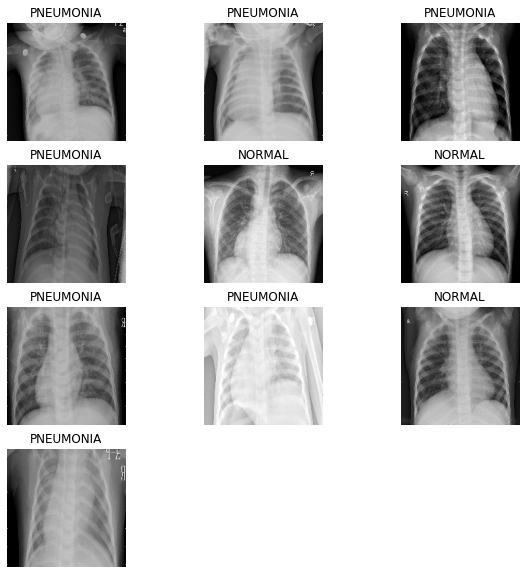

In [55]:
#데이터 시각화

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [56]:
#Step 4. CNN 모델링
#cvl filter
#채널 개수
#액티베이션
#모델 구조
#배치노말라이제이션 드랍아웃

In [57]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#
#
#
#
#

In [58]:
#Step 5. 데이터 imbalance 처리
#생략한다면?
#리콜을 강조하기 위해 페렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까

In [59]:
#훈련 데이터의 정상 이미지 수와 폐렴 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [60]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  #노말이미지에 사용할 웨이트
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 #폐렴이미지에 사용할 웨이트

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [61]:
#Step 6. 모델 훈련
#옵티마이저 변경
#러닝레이트 변경

In [81]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [ #성과에 대해 측정하기위한 metrics로 accuracy, precision, recall 사용
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='RMSProp', #옵티마이저로 RMSProp 사용
        loss='binary_crossentropy', #이미지 라벨이 두개 밖에 없기 때문에 'binary_crossentropy' loss 사용
        metrics=METRICS
    )

In [82]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
418/418 [==============================] - 60s 121ms/step - loss: 0.5130 - accuracy: 0.7517 - precision: 0.9180 - recall: 0.7313 - val_loss: 0.6682 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/20
418/418 [==============================] - 49s 118ms/step - loss: 0.3218 - accuracy: 0.8797 - precision: 0.9543 - recall: 0.8804 - val_loss: 0.2248 - val_accuracy: 0.9135 - val_precision: 0.9042 - val_recall: 0.9869
Epoch 3/20
418/418 [==============================] - 50s 120ms/step - loss: 0.2839 - accuracy: 0.8964 - precision: 0.9627 - recall: 0.8956 - val_loss: 0.5603 - val_accuracy: 0.7721 - val_precision: 0.7639 - val_recall: 1.0000
Epoch 4/20
418/418 [==============================] - 50s 120ms/step - loss: 0.2303 - accuracy: 0.9151 - precision: 0.9722 - recall: 0.9117 - val_loss: 0.5590 - val_accuracy: 0.8231 - val_precision: 1.0000 - val_recall: 0.7598
Epoch 5/20
418/418 [==============================] - 50s 120ms/step - loss: 0.2202 - accura

In [83]:
#Step 7. 결과 확인과 시각화
#accuracy, recall 값 확인
#훈련과정의 history그래프를 시각화해보고 학습 진행 양상을 면밀히 분석

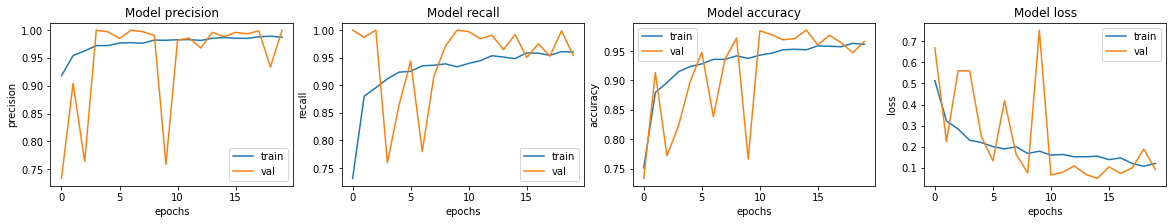

In [84]:
#시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [86]:
#val 수치가 에폭 10 전에는 값이 많이 튀었는데 에폭 10 이후로는 안정되는 모습을 보여준다. 학습은 최소 10 에폭은 진행해야 될 것 같다.

In [85]:
#결과 확인

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 5s 71ms/step - loss: 0.7338 - accuracy: 0.8462 - precision: 0.8128 - recall: 0.9795
Loss: 0.7337940335273743,
Accuracy: 0.8461538553237915,
Precision: 0.8127659559249878,
Recall: 0.9794871807098389


In [ ]:
#Optimizer를 Adam에서 AdaDelta로 변경해보았으나 Adam보다 정확도가 2%가량 낮아 RMSProp 를 사용해보았는데 
#7에폭만 학습시켰는데도 정확도가 상당히 높게 나와서 20 에폭으로 늘린 상태에서 학습을 진행하였고 정확도에서 많은 폭으로 상승하였다. 